# **IDS 576: Assignment 2**

# Problem 1

**CNNs and finetuning (4pt)** 

Download the CIFAR 10 dataset. Use the pretrained Resnet18 model (from trochvision) to extract features. Use the features as inputs in a new multi-class logistic regression model (use nn.Linear/ nn.Module to define your model) 

**PART A :** Describe any choices made and report test performance.

**PART B:** Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.


We made the following choices:
1.   Loss Function : Log Loss Cross Entropy
2.   Learning Rate : 0.001
3.   Momentum : 0.9
4.   Scheduler step_size : 7
5.   gamma : 0.1 
6.   num_epochs : 10








In [7]:
conda install numpy jupyter notebook  
import pickle
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
import heapq

drive.mount('/content/drive')
%cd /content/drive/My Drive/Assignment_2/
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SyntaxError: invalid syntax (<ipython-input-7-4393f904a119>, line 1)

In [ ]:
# this code was reused from https://github.com/snatch59/load-cifar-10 as coded by Petras Saduikis
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    #else:
        #cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    #else:
        #cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [ ]:
cifar_10_dir = '/content/drive/My Drive/Assignment_2/cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataset_size = train_data.shape[0]

    for epoch in range(num_epochs):
        print('Training Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # training phase
        phase = 'train'
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data. must be from 0 to 500
        for i in range(0, 500):
            print ('running iter='+str(i))
            inputs = train_data[i*100:(i+1)*100:,:]
            labels = train_labels[i*100:(i+1)*100]

            # zero the parameter gradients
            optimizer.zero_grad()

            inputs = torch.from_numpy(inputs)
            labels = torch.from_numpy(labels)

            inputs = inputs.type(torch.FloatTensor)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                #perform backword and optimize in training
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()   
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))             
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

##################################################################################

def validate_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataset_size = train_data.shape[0]

    # validation phase
    phase = 'Val'
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data. must be from 0 to 99
    for i in range(0,100):
        print ('running iter='+str(i))
        inputs = test_data[i*100:(i+1)*100:,:]
        labels = test_labels[i*100:(i+1)*100]

        # zero the parameter gradients
        optimizer.zero_grad()

        inputs = torch.from_numpy(inputs)
        labels = torch.from_numpy(labels)

        inputs = inputs.type(torch.FloatTensor)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))             
  
    time_elapsed = time.time() - since
    print('validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return epoch_loss, epoch_acc
#####################################################################################

model_ft = torchvision.models.resnet18(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
nn.Linear(num_ftrs, 10)
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)
a, b = validate_model(trained_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=2)

cifar_10_dir = '/content/drive/My Drive/Assignment_2/saved_model-problemb.pkl'

with open(cifar_10_dir, 'wb') as fo:
    pickle.dump(trained_model, fo)

In [ ]:
i = 0
total_c = 10000

inputs = test_data[i*total_c:(i+1)*total_c:,:]
labels = test_labels[i*total_c:(i+1)*total_c]

inputs = torch.from_numpy(inputs)
labels = torch.from_numpy(labels)

inputs = inputs.type(torch.FloatTensor)

with torch.no_grad():
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)

prob = torch.nn.functional.softmax(outputs, dim=1)
top_p, top_class = prob.topk(1, dim = 1)
top_p = top_p.numpy()

x = heapq.nlargest(5, range(len(top_p)), top_p.take)
y = heapq.nsmallest(5, range(len(top_p)), top_p.take)

for m in range(len(x)):
  print("Confidence = " + str(top_p[x[m]]) + " good - predicted = " + str(label_names[preds[x[m]]]) + " actual = " + str(label_names[test_labels[x[m]]]))

for m in range(len(y)):
  print("Confidence = " + str(top_p[y[m]]) + " bad - predicted = " + str(label_names[preds[y[m]]]) + " actual = " + str(label_names[test_labels[y[m]]]))

Confidence = [0.9997893] good - predicted = b'dog' actual = b'dog'
Confidence = [0.9992694] good - predicted = b'dog' actual = b'dog'
Confidence = [0.99851257] good - predicted = b'automobile' actual = b'automobile'
Confidence = [0.99840766] good - predicted = b'dog' actual = b'dog'
Confidence = [0.9983039] good - predicted = b'horse' actual = b'horse'
Confidence = [0.13025174] bad - predicted = b'frog' actual = b'cat'
Confidence = [0.13088979] bad - predicted = b'ship' actual = b'truck'
Confidence = [0.13343932] bad - predicted = b'horse' actual = b'frog'
Confidence = [0.13664371] bad - predicted = b'dog' actual = b'airplane'
Confidence = [0.13787311] bad - predicted = b'horse' actual = b'cat'


**PART C:** Finetune the Resnet18 model's parameters suitably and repeat parts (a) and (b) from above. Compare the performance of finetuning versus using extracted features.

In [ ]:
import pickle
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
import heapq

drive.mount('/content/drive')
%cd /content/drive/My Drive/Assignment_2/
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/My Drive/Assignment_2


In [ ]:
# this code was reused from https://github.com/snatch59/load-cifar-10 as coded by Petras Saduikis
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    #else:
        #cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    #else:
        #cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [ ]:
cifar_10_dir = '/content/drive/My Drive/Assignment_2/cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataset_size = train_data.shape[0]

    for epoch in range(num_epochs):
        print('Training Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # training phase
        phase = 'train'
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data. must be from 0 to 500
        for i in range(0, 500):
            print ('running iter='+str(i))
            inputs = train_data[i*100:(i+1)*100:,:]
            labels = train_labels[i*100:(i+1)*100]

            # zero the parameter gradients
            optimizer.zero_grad()

            inputs = torch.from_numpy(inputs)
            labels = torch.from_numpy(labels)

            inputs = inputs.type(torch.FloatTensor)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                #perform backword and optimize in training
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()   
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))             
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

##################################################################################

def validate_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataset_size = train_data.shape[0]

    # validation phase
    phase = 'Val'
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data. must be from 0 to 99
    for i in range(0,100):
        print ('running iter='+str(i))
        inputs = test_data[i*100:(i+1)*100:,:]
        labels = test_labels[i*100:(i+1)*100]

        # zero the parameter gradients
        optimizer.zero_grad()

        inputs = torch.from_numpy(inputs)
        labels = torch.from_numpy(labels)

        inputs = inputs.type(torch.FloatTensor)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))             
  
    time_elapsed = time.time() - since
    print('validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return epoch_loss, epoch_acc
#####################################################################################

model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
nn.Linear(num_ftrs, 10)
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)
a, b = validate_model(trained_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=2)
print("Loss = ", a)
print("Accuracy = ", b)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Streaming output truncated to the last 5000 lines.
running iter=232
running iter=233
running iter=234
running iter=235
running iter=236
running iter=237
running iter=238
running iter=239
running iter=240
running iter=241
running iter=242
running iter=243
running iter=244
running iter=245
running iter=246
running iter=247
running iter=248
running iter=249
running iter=250
running iter=251
running iter=252
running iter=253
running iter=254
running iter=255
running iter=256
running iter=257
running iter=258
running iter=259
running iter=260
running iter=261
running iter=262
running iter=263
running iter=264
running iter=265
running iter=266
running iter=267
running iter=268
running iter=269
running iter=270
running iter=271
running iter=272
running iter=273
running iter=274
running iter=275
running iter=276
running iter=277
running iter=278
running iter=279
running iter=280
running iter=281
running iter=282
running iter=283
running iter=284
running iter=285
running iter=286
running iter=2

In [ ]:
i = 0
total_c = 10000

inputs = test_data[i*total_c:(i+1)*total_c:,:]
labels = test_labels[i*total_c:(i+1)*total_c]

inputs = torch.from_numpy(inputs)
labels = torch.from_numpy(labels)

inputs = inputs.type(torch.FloatTensor)

with torch.no_grad():
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)

prob = torch.nn.functional.softmax(outputs, dim=1)
top_p, top_class = prob.topk(1, dim = 1)
top_p = top_p.numpy()

x = heapq.nlargest(5, range(len(top_p)), top_p.take)
y = heapq.nsmallest(5, range(len(top_p)), top_p.take)

for m in range(len(x)):
  print("Confidence = " + str(top_p[x[m]]) + " good - predicted = " + str(label_names[preds[x[m]]]) + " actual = " + str(label_names[test_labels[x[m]]]))

for m in range(len(y)):
  print("Confidence = " + str(top_p[y[m]]) + " bad - predicted = " + str(label_names[preds[y[m]]]) + " actual = " + str(label_names[test_labels[y[m]]]))

Confidence = [1.] good - predicted = b'truck' actual = b'truck'
Confidence = [1.] good - predicted = b'truck' actual = b'truck'
Confidence = [1.] good - predicted = b'airplane' actual = b'airplane'
Confidence = [1.] good - predicted = b'cat' actual = b'cat'
Confidence = [1.] good - predicted = b'ship' actual = b'ship'
Confidence = [0.23327777] bad - predicted = b'dog' actual = b'cat'
Confidence = [0.24535415] bad - predicted = b'airplane' actual = b'horse'
Confidence = [0.24545956] bad - predicted = b'frog' actual = b'bird'
Confidence = [0.26807374] bad - predicted = b'horse' actual = b'cat'
Confidence = [0.27319488] bad - predicted = b'horse' actual = b'cat'


**Clearly there is a trade off between speed vs accuracy between these two models.** 

Extracted features
*   Train Loss: 1.5065 Acc: 0.4794
*   Training complete in 23m 38s
*   Val Loss: 0.3138 Acc: 0.0926
*   Validation complete in 0m 23s
*   Confidence range : 0.9997893 to 0.13025174

Finetune Features

* Train Loss: 0.0064 Acc: 1.0000
* Training complete in 101m 1s
* Val Loss: 0.2321 Acc: 0.1536
* Validation complete in 0m 26s
* Confidence range : 1.0 to 0.23327777


# Problem 2

2. Instead of embedding words, we will embed movies. In particular, if we can embed movies, then similar movies will be close to each other and can be recommended. This line of reasoning is analogous to the distributional hypothesis of word meanings. For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people.

  Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.

**PART A:** Compute data $X_{i,j}$ from the movielens (small) dataset and description. Briefly describe your data prep workflow (you can use pandas if needed).

In [ ]:
import pickle
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from google.colab import drive
import tensorflow as tf
import torch
import math
import numpy as np

drive.mount('/content/drive')
%cd /content/drive/My Drive/Assignment_2/movielens
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('ratings.csv')
df = df.drop(columns='timestamp')
df = df[df['rating']> 3.0]
df.reset_index(inplace=True) 
df2 = df.merge(df, how='inner', on='userId')
df3 = df2.pivot_table(index='movieId_x',columns='movieId_y', values='userId', aggfunc='count')
df2 = ""
print(df3)

Mounted at /content/drive
/content/drive/My Drive/Assignment_2/movielens
movieId_y  1       2       3       5       ...  193583  193585  193587  193609
movieId_x                                  ...                                
1           165.0    31.0    14.0     8.0  ...     NaN     NaN     NaN     NaN
2            31.0    61.0     5.0     4.0  ...     NaN     NaN     NaN     NaN
3            14.0     5.0    23.0     4.0  ...     NaN     NaN     NaN     NaN
5             8.0     4.0     4.0    13.0  ...     NaN     NaN     NaN     NaN
6            32.0    12.0     5.0     3.0  ...     NaN     NaN     NaN     NaN
...           ...     ...     ...     ...  ...     ...     ...     ...     ...
193581        NaN     NaN     NaN     NaN  ...     1.0     1.0     1.0     NaN
193583        NaN     NaN     NaN     NaN  ...     1.0     1.0     1.0     NaN
193585        NaN     NaN     NaN     NaN  ...     1.0     1.0     1.0     NaN
193587        NaN     NaN     NaN     NaN  ...     1.0    

**Data Prep Workflow**

Our Data Prep and Computations Process were as follows:

Step 1: Loading the necessary packages

Step 2: Connecting the correct Google Drive filepath and reading the data

Step 3: Filtering the data and creating a Pivot Table that calculates the # of users that liked both movies i & j going diagonally across


**PART B:** Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using pytorch or tensorflow). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).

In [ ]:
import pickle

class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.moviematrix = torch.nn.Parameter(torch.rand(7363, 3))

    def forward(self, m1, m2):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        a = self.moviematrix[m1]
        b = self.moviematrix[m2]
        c = torch.matmul(a,b)
        #print("c",c)
        #print("m1",m1)
        return c

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return str(self.moviematrix)

def my_loss_fn(y_pred, y_actual):
      d = y_pred - y_actual
      d = d*d
      return d

model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the nn.Linear
# module which is members of the model.
criterion = my_loss_fn
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

#df = pd.read_csv('ratings.csv')
#df = df.drop(columns='timestamp')
#df = df[df['rating']> 3.0]
#df.reset_index(inplace=True) 
#df2 = df.merge(df, how='inner', on='userId')
#df3 = df2.pivot_table(index='movieId_x',columns='movieId_y', values='userId', aggfunc='count')

len_matrix = df3.shape[0]
epoch = 1
#len_matrix = 200

for i in range(epoch):
  for p in range(len_matrix):
      for q in range (len_matrix):
          # Forward pass: Compute predicted y by passing x to the model
          y_pred = model(p,q)

          # Compute and print loss
          abc = df3.iat[p,q]
          if np.isnan(abc):
            abc=0
          if p!=q :
            loss = criterion(y_pred, abc)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          if p % 1000 == 999:
            print(y_pred, abc)

          # Zero gradients, perform a backward pass, and update the weights.


print(f'Result: {model.string()}')

with open('movie_data.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

Streaming output truncated to the last 5000 lines.
tensor(0.9725, grad_fn=<DotBackward>) 0
tensor(1.1262, grad_fn=<DotBackward>) 0
tensor(0.8590, grad_fn=<DotBackward>) 0
tensor(0.9556, grad_fn=<DotBackward>) 0
tensor(0.7429, grad_fn=<DotBackward>) 0
tensor(0.6883, grad_fn=<DotBackward>) 0
tensor(0.7263, grad_fn=<DotBackward>) 0
tensor(0.4804, grad_fn=<DotBackward>) 0
tensor(0.5410, grad_fn=<DotBackward>) 0
tensor(0.5575, grad_fn=<DotBackward>) 0
tensor(1.0204, grad_fn=<DotBackward>) 0
tensor(0.8866, grad_fn=<DotBackward>) 0
tensor(0.9328, grad_fn=<DotBackward>) 0
tensor(0.4285, grad_fn=<DotBackward>) 0
tensor(0.5853, grad_fn=<DotBackward>) 0
tensor(0.9070, grad_fn=<DotBackward>) 0
tensor(0.5960, grad_fn=<DotBackward>) 0
tensor(1.0406, grad_fn=<DotBackward>) 0
tensor(0.3913, grad_fn=<DotBackward>) 0
tensor(1.0270, grad_fn=<DotBackward>) 0
tensor(0.9357, grad_fn=<DotBackward>) 0
tensor(0.6880, grad_fn=<DotBackward>) 0
tensor(0.9119, grad_fn=<DotBackward>) 0
tensor(0.8712, grad_fn=<DotBa

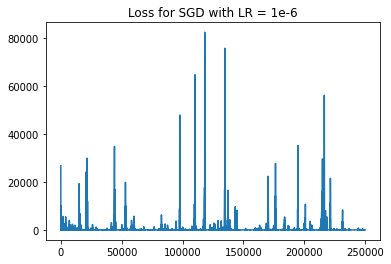

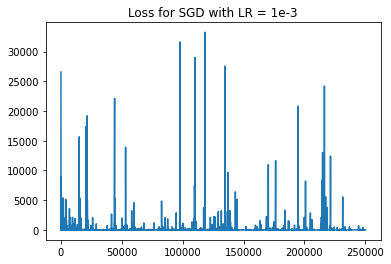

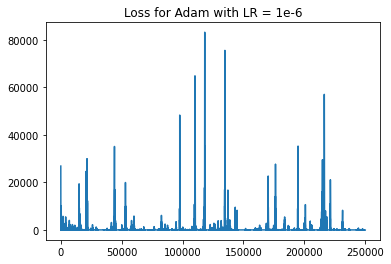

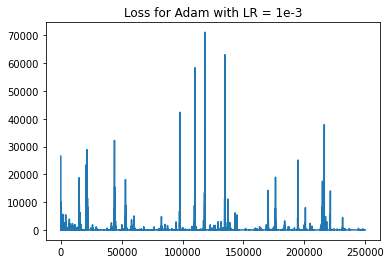

In [ ]:
class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.moviematrix = torch.nn.Parameter(torch.rand(7363, 3))

    def forward(self, m1, m2):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        a = self.moviematrix[m1]
        b = self.moviematrix[m2]
        c = torch.matmul(a,b)
        #print("c",c)
        #print("m1",m1)
        return c

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return str(self.moviematrix)

def my_loss_fn(y_pred, y_actual):
      d = y_pred - y_actual
      d = d*d
      return d

def plot_loss(optim_var, lr_value):
    model = Polynomial3()

    criterion = my_loss_fn

    #lr_value = 1e-3 or 1e-6
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_value)
    if optim_var == 1:
      optimizer = torch.optim.Adam(model.parameters(), lr=lr_value)
      #print("set adam")

    len_matrix = df3.shape[0]
    epoch = 1
    len_matrix = 500

    loss_4graph = y=np.empty(len_matrix*len_matrix)
    itel_loca =  0
    for i in range(epoch):
      for p in range(len_matrix):
          for q in range (len_matrix):
              # Forward pass: Compute predicted y by passing x to the model
              y_pred = model(p,q)

              # Compute and print loss
              abc = df3.iat[p,q]
              if np.isnan(abc):
                abc=0
              loss = criterion(y_pred, abc)
              #print(p, loss.item())
              loss_4graph[itel_loca] = loss.item()
              itel_loca = itel_loca + 1

              # Zero gradients, perform a backward pass, and update the weights.
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
    return loss_4graph

loss1 = plot_loss(0, 1e-6)
plt.plot(loss1)
plt.title("Loss for SGD with LR = 1e-6")
plt.show()

loss2 = plot_loss(0, 1e-3)
plt.plot(loss2)
plt.title("Loss for SGD with LR = 1e-3")
plt.show()

loss3 = plot_loss(1, 1e-6)
plt.plot(loss3)
plt.title("Loss for Adam with LR = 1e-6")
plt.show()

loss4 = plot_loss(1, 1e-3)
plt.plot(loss4)
plt.title("Loss for Adam with LR = 1e-3")
plt.show()

**PART C:** Recommend top 10 movies (not vectors or indices but movie names) given movies 

(a) Apollo 13, 

(b) Toy Story, and 

(c) Home Alone. 

Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?

**Recommendation Strategy**

The model predicts the number of users that liked two movies provided as input. Therefore strategy to recommend is noted as follows

Step 1 : predict the number of users that would like every combination of Input Movie and every other movie. Note that the model uses movie index, therefore the movie ID is converted to movie index before performing this step.

Step 2 : Find the movies with top 10 largest predicted predictions from step 1.



In [ ]:
import heapq

movies = pd.read_csv('movies.csv')

def get_top10(name):
    spec_movie = movies[movies['title'] == name]
    movie_id = spec_movie.iloc[0]['movieId']
    movie_index = 0

    i=0
    for row in df3.index: 
        if row == movie_id:
          movie_index = i
          break
        i = i + 1

    y=np.empty(df3.shape[0])
    for i in range(df3.shape[0]):
        y[i] = model(movie_index, i)

    #top_ten = np.argpartition(y,10)[:10]
    top_ten = heapq.nlargest(10, range(len(y)), y.__getitem__)
    x = heapq.nlargest(10, y)
    print(x)
    print("Top 10 Recommendations for ", name)
    for i in range(10):
      refer_index = df3.index[top_ten[i]]
      x = movies[movies['movieId'] == refer_index]
      print(x)

get_top10('Apollo 13 (1995)')
print("#"*100)
get_top10('Toy Story (1995)')
print("#"*100)
get_top10('Home Alone (1990)')

[0.8633716106414795, 0.8617627620697021, 0.8611460328102112, 0.858887791633606, 0.8585185408592224, 0.8540441989898682, 0.8424514532089233, 0.8419991731643677, 0.840487539768219, 0.83722984790802]
Top 10 Recommendations for  Apollo 13 (1995)
      movieId          title genres
6913    64197  Hunger (2008)  Drama
      movieId            title           genres
4467     6595  S.W.A.T. (2003)  Action|Thriller
      movieId              title genres
4195     6055  Sugar Hill (1994)  Drama
      movieId               title         genres
3908     5490  The Big Bus (1976)  Action|Comedy
      movieId                title                  genres
2974     3986  6th Day, The (2000)  Action|Sci-Fi|Thriller
      movieId                             title                         genres
7737    90746  Adventures of Tintin, The (2011)  Action|Animation|Mystery|IMAX
      movieId               title                 genres
4755     7080  42nd Street (1933)  Drama|Musical|Romance
      movieId  ...    